In [2]:
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve

In [61]:
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

TIC_ID = params['TIC ID']
TOI = params['TOI']

index = int(196)

tic_id = int(TIC_ID[index])
toi = TOI[index]
observatory = 'TESS'

print('TIC {:.0f}'.format(tic_id))
print('TOI {:.2f}'.format(toi))

TIC 441798995
TOI 2269.03


In [35]:
tic_id = '441798995'
lcf = lk.search_lightcurvefile('TIC {}'.format(int(tic_id))).download_all()
lcf

LightCurveFileCollection of 13 objects:
	TIC 441798995 (13 TessLightCurveFiles) Sectors: 14,15,16,17,18,19,20,21,22,23,24,25,26

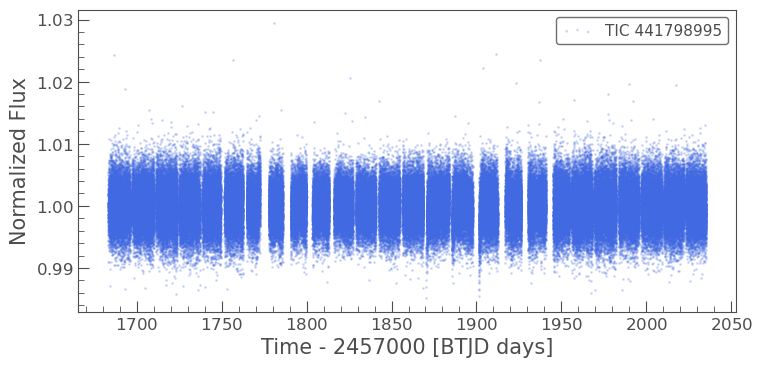

In [36]:
stitched_lc = lcf.PDCSAP_FLUX.stitch().remove_outliers(sigma=10)
stitched_lc.scatter(alpha=0.2,color='royalblue')

In [62]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = (1-ppm_depth/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

In [63]:
folded_lc = stitched_lc.fold(period=planet_period, t0=Epoch)#.bin(binsize=10)

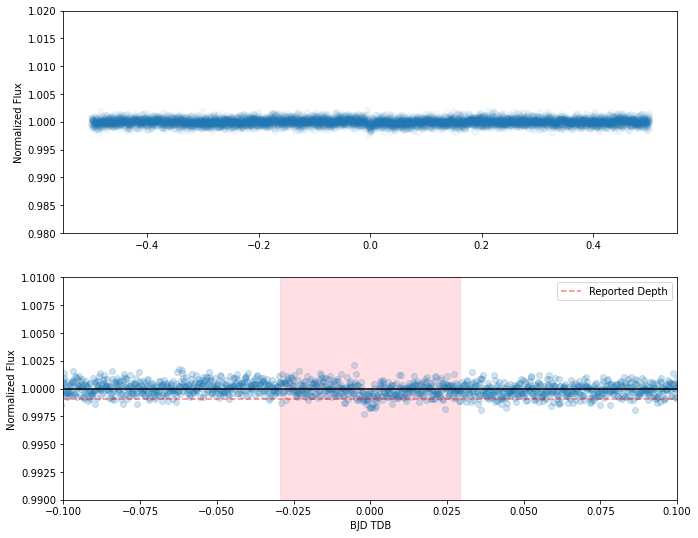

In [64]:
TLC = folded_lc
n = 0

'''
n = [0, 1, 3, 14, 14, 15, 15] for TOI 203
n = []
'''

fig, (ax0,ax1) = plt.subplots(2,1,figsize=(11,9))

#init_model = BATMAN(planet_period,planet_radius,t0=Epoch,inc=planet_i,
#                    A=planet_a,LD=[0.31,0.32],t = TLC.time)


#ingress = (Epoch+n*planet_period)-(planet_duration/2)/24
ingress = 0-(planet_duration/2)/24
#egress = (Epoch+n*planet_period)+(planet_duration/2)/24
egress = 0+(planet_duration/2)/24

ax0.scatter(TLC.bin(binsize=30).time, TLC.bin(binsize=30).flux, alpha=0.05,rasterized=True, label = 'Folded TESS light curve, alpha = 0.05')
#ax0.axvspan(ingress, egress, alpha=0.5, color='pink')

ax0.set_ylabel('Normalized Flux')
ax0.set_ylim(0.98,1.02)
#ax0.set_xlim(ingress-30,egress+30)
ax1.legend()


ax1.scatter(TLC.bin(binsize=30).time, TLC.bin(binsize=30).flux, alpha=0.2,rasterized=True)
ax1.axvspan(ingress, egress, alpha=0.5, color='pink',zorder=-2)
ax1.axhline(1, color='k',zorder=100)
ax1.axhline(depth, color='r',zorder=100,label='Reported Depth',linestyle='--',alpha=0.5)
#ax1.plot(TLC.time, init_model, color='k',zorder=-1)

ax1.set_xlim(-0.1, 0.1)
ax1.set_ylim(0.99,1.01)
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('BJD TDB')
ax1.legend()

plt.savefig('Figs/TIC{}.03_folded_TESSlc.pdf'.format(tic_id,n))
plt.show()